### Goals for Milestone 3:
<li> Build to daily values </li>
<li> Save off and reload </li>
<li> Build regression </li>
<li> Explain components of outputs </li>
<li> Calculate Betas for Tech Scenario </li>
<li> Evaluate Markets for Environmental Services </li>

In [5]:
fedkey = 'Need To Input Your FRed API Key Here'

### Get libraries

In [1]:
import os
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import statsmodels.api as sm
from matplotlib import pyplot as plt
from fredapi import Fred

### Scenario 1: Tech sector Q1'21

In [2]:
### parameters
### tech stocks and use the S&P500 as market
tickers = ['AAPL','IBM','INTC','MSFT','^GSPC']

### FRED series code for 3-month T-bill
rf_series = 'DGS3MO'

### dates and interval
_start = '2021-01-01'
_end = '2021-04-01'
_fedend = '2021-03-31'
_interval = '1d'

In [3]:
### Stock data
techstock = yf.download(tickers
                        , start=_start
                        , end=_end
                        , interval=_interval)

tech_prices=techstock['Close']
tech_prices=tech_prices.rename({'^GSPC':'GSPC'}, axis='columns')

[*********************100%%**********************]  5 of 5 completed


In [6]:
### Risk-free rate data
fred = Fred(api_key = fedkey)
risk_free=fred.get_series(series_id = rf_series).dropna()
risk_free=risk_free[_start: _fedend]
risk_free_daily = risk_free/252

In [7]:
### Single dataframe for modeling
tech_prices_returns = tech_prices.pct_change().dropna()
risk_free_daily = risk_free/252
scen1_returns = tech_prices_returns.join(risk_free_daily.rename('rf_daily'))

### Calculate excess returns
tech_scen = ["AAPL", "IBM", "MSFT", "INTC", "GSPC"]
for i in tech_scen:
    scen1_returns["xs_rtn_"+str(i)] = scen1_returns[i] - scen1_returns['rf_daily']

In [8]:
### A look pre-modeling
scen1_returns.tail(5)

,AAPL,IBM,INTC,MSFT,GSPC,rf_daily,xs_rtn_AAPL,xs_rtn_IBM,xs_rtn_MSFT,xs_rtn_INTC,xs_rtn_GSPC
Date,,,,,,,,,,,
2021-03-25,0.004164,0.018757,-0.000322,-0.013251,0.005240,0.000079,0.004084,0.018677,-0.013330,-0.000402,0.005161
2021-03-26,0.005141,0.024874,0.045953,0.017819,0.016631,0.000079,0.005062,0.024795,0.017739,0.045874,0.016552
2021-03-29,0.001485,-0.003813,-0.005704,-0.005244,-0.000868,0.000119,0.001366,-0.003932,-0.005363,-0.005823,-0.000987
2021-03-30,-0.012274,-0.008391,-0.011318,-0.014411,-0.003158,0.000079,-0.012354,-0.008470,-0.014490,-0.011397,-0.003237
2021-03-31,0.018766,-0.010837,0.003607,0.016907,0.003622,0.000119,0.018647,-0.010956,0.016788,0.003488,0.003503


## Good Practice - save your data version

In [9]:
### Save off for re-runs?
os.chdir('B:\\Documents\\Manning')
os.getcwd()
scen1_returns.to_csv('scen1_tech_returns.csv')

In [10]:
input_to_model = pd.read_csv('scen1_tech_returns.csv', index_col="Date")
input_to_model.head()

,AAPL,IBM,INTC,MSFT,GSPC,rf_daily,xs_rtn_AAPL,xs_rtn_IBM,xs_rtn_MSFT,xs_rtn_INTC,xs_rtn_GSPC
Date,,,,,,,,,,,
2021-01-05,0.012364,0.017751,0.018925,0.000965,0.007083,0.000357,0.012007,0.017393,0.000607,0.018568,0.006725
2021-01-06,-0.033662,0.024972,0.009682,-0.025929,0.005710,0.000357,-0.034019,0.024615,-0.026286,0.009325,0.005353
2021-01-07,0.034123,-0.002320,0.021331,0.028457,0.014847,0.000357,0.033766,-0.002678,0.028100,0.020974,0.014490
2021-01-08,0.008631,-0.003566,-0.010347,0.006093,0.005492,0.000317,0.008314,-0.003884,0.005775,-0.010664,0.005174
2021-01-11,-0.023249,0.000389,-0.002130,-0.009699,-0.006555,0.000317,-0.023566,0.000072,-0.010016,-0.002447,-0.006872


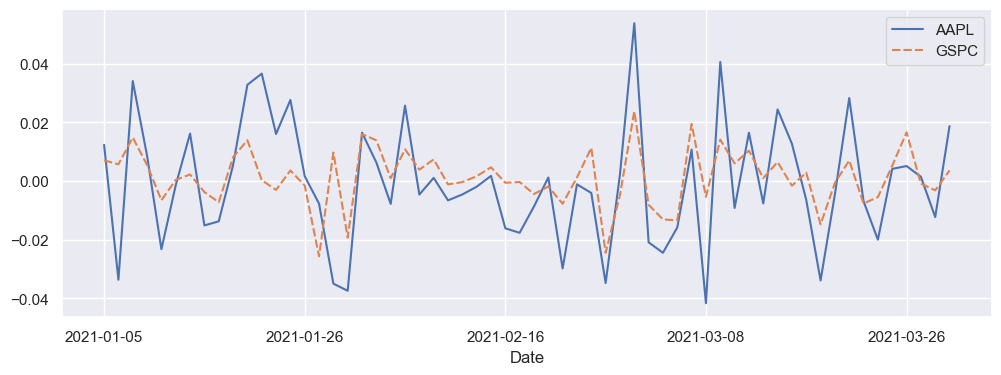

In [11]:

plt.figure(figsize=(12,4))
sns.lineplot(input_to_model[['AAPL','GSPC']])
## Clean up the x-axis
step_size = 14
plt.xticks(ticks=range(0, len(input_to_model), step_size))

plt.show()

### The relationship we suspect

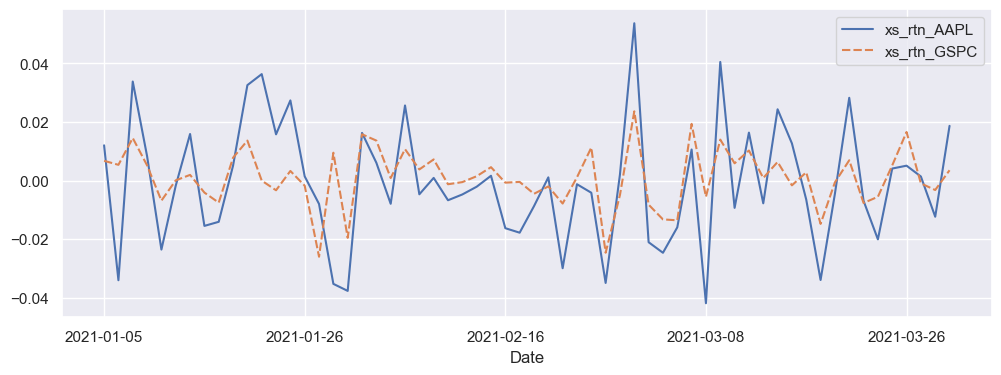

In [12]:
plt.figure(figsize=(12,4))
sns.lineplot(input_to_model[['xs_rtn_AAPL','xs_rtn_GSPC']])
step_size = 14
plt.xticks(ticks=range(0, len(input_to_model), step_size))
plt.show()

## Now generate the model

In [13]:
### Create two pandas series to input to model
y_aapl = input_to_model['xs_rtn_AAPL']
X = input_to_model['xs_rtn_GSPC']

In [14]:
### Constant value captures variation not explained by market
X = sm.add_constant(X, prepend=False)
print(type(X))
print(X.head())

<class 'pandas.core.frame.DataFrame'>
            xs_rtn_GSPC  const
Date                          
2021-01-05     0.006725    1.0
2021-01-06     0.005353    1.0
2021-01-07     0.014490    1.0
2021-01-08     0.005174    1.0
2021-01-11    -0.006872    1.0


In [15]:
### Call to statsmodels OLS object to create model
CAPM_AAPL = sm.OLS(y_aapl, X)
print(type(CAPM_AAPL))

<class 'statsmodels.regression.linear_model.OLS'>


In [16]:
### Fit model to data
CAPM_results_AAPL = CAPM_AAPL.fit()
print(type(CAPM_results_AAPL))

<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>


In [17]:
## Share results
CAPM_results_AAPL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            xs_rtn_AAPL   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     44.08
Date:                Sat, 28 Sep 2024   Prob (F-statistic):           1.18e-08
Time:                        23:54:34   Log-Likelihood:                 164.60
No. Observations:                  60   AIC:                            -325.2
Df Residuals:                      58   BIC:                            -321.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
xs_rtn_GSPC     1.3889      0.209      6.640      0.000       0.970       1.808
const          -0.0024      0.002     -1.158      0.252      -0.006       0.002
==============================================================================
Omnibus:                        2.641   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.267   Jarque-Bera (JB):                1.938
Skew:                          -0.185   Prob(JB):                        0.379
Kurtosis:                       3.799   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Break down the model outputs

In [18]:
## We're really interested in coefficients and significance
CAPM_results_AAPL.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
xs_rtn_GSPC,1.388851,0.209178,6.639572,1.178356e-08,0.970136,1.807566
const,-0.002381,0.002056,-1.158249,2.515096e-01,-0.006497,0.001734


In [19]:
# Beta coefficient is the variation with the market
# Alpha is variation unexplained by market
CAPM_results_AAPL.params

xs_rtn_GSPC    1.388851
const         -0.002381
dtype: float64

## Break down the model outputs

In [20]:
## We're really interested in coefficients and significance
CAPM_results_AAPL.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
xs_rtn_GSPC,1.388851,0.209178,6.639572,1.178356e-08,0.970136,1.807566
const,-0.002381,0.002056,-1.158249,2.515096e-01,-0.006497,0.001734


In [21]:
# T-value measures Beta's significance from zero
CAPM_results_AAPL.tvalues

xs_rtn_GSPC    6.639572
const         -1.158249
dtype: float64

## Break down the model outputs

In [22]:
## We're really interested in coefficients and significance
CAPM_results_AAPL.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
xs_rtn_GSPC,1.388851,0.209178,6.639572,1.178356e-08,0.970136,1.807566
const,-0.002381,0.002056,-1.158249,2.515096e-01,-0.006497,0.001734


In [35]:
# Beta Standard Error measures significance from 1
1.96 * CAPM_results_AAPL.bse

xs_rtn_GSPC    0.409988
const          0.004030
dtype: float64

### A tidy explaining function

In [24]:
def eval_model(in_model, in_market) -> None:
    """ Evaluates the CAPM model for a given stock against a market benchmark.
    Params
    in_model : output from our .fit()
    in_market : The name of the market factor (i.e. "xs_rtn_GSPC")
    """
    _beta = in_model.params
    _tval = in_model.tvalues
    _sebeta = in_model.bse
    appear, meaning,  = ('less','not')
    if _beta[in_market] > 1.0:
        appear = 'more'
    if _beta[in_market] - (1.96* _sebeta[in_market]) > 1:
        meaning = ''
    print("""The stock appears to be %s volatile than the market, 
             Beta is %s than 1, %s statistically.""" %(appear,appear,meaning))
    if 1.96 > _tval[in_market] > -1.96:
        print("The stock may be uncorrelated with the market.")
    elif _tval[in_market] >= 1.96:
        print("The stock is sensitive to the market's movements.")
    elif _tval[in_market] <= -1.96:
        print("""The stock is negatively correlated with 
        the market and may be a hedge.""")
    if 1.96 > _tval['const'] > -1.96:
        print("""The alpha is not significantly different from zero
        . Market appears efficient.""")
    elif _beta['const'] > 0 :
        print("Potential for excess returns.")
    elif _beta['const'] < 0:
        print("Red flag. Stock consistently underperforms CAPM prediction.")

In [25]:
CAPM_results_AAPL.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
xs_rtn_GSPC,1.388851,0.209178,6.639572,1.178356e-08,0.970136,1.807566
const,-0.002381,0.002056,-1.158249,2.515096e-01,-0.006497,0.001734


In [26]:
eval_model(CAPM_results_AAPL, 'xs_rtn_GSPC')

The stock appears to be more volatile than the market, 
             Beta is more than 1, not statistically.
The stock is sensitive to the market's movements.
The alpha is not significantly different from zero
        . Market appears efficient.


In [27]:
### Iterate over all tech stocks
print(tech_scen[1:])

['IBM', 'MSFT', 'INTC', 'GSPC']


## IBM on S&P500

In [28]:
print("________________CAPM analysis on IBM________________")
y_ibm = input_to_model['xs_rtn_IBM']
X = sm.add_constant(X, prepend=False)
CAPM_IBM = sm.OLS(y_ibm, X)
CAPM_results_IBM = CAPM_IBM.fit()
CAPM_results_IBM.summary2().tables[1]

________________CAPM analysis on IBM________________


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
xs_rtn_GSPC,0.446072,0.238780,1.868135,0.066797,-0.031897,0.924042
const,0.000721,0.002347,0.307432,0.759616,-0.003976,0.005419


In [29]:
eval_model(CAPM_results_IBM, 'xs_rtn_GSPC')

The stock appears to be less volatile than the market, 
             Beta is less than 1, not statistically.
The stock may be uncorrelated with the market.
The alpha is not significantly different from zero
        . Market appears efficient.


## MSFT on S&P500

In [30]:
print("________________CAPM analysis on MSFT________________")
y_msft = input_to_model['xs_rtn_MSFT']
X = sm.add_constant(X, prepend=False)
CAPM_MSFT = sm.OLS(y_msft, X)
CAPM_results_MSFT = CAPM_MSFT.fit()
CAPM_results_MSFT.summary2().tables[1]

________________CAPM analysis on MSFT________________


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
xs_rtn_GSPC,1.046009,0.158426,6.602516,1.359091e-08,0.728886,1.363133
const,0.000173,0.001557,0.111270,9.117860e-01,-0.002944,0.003290


In [31]:
eval_model(CAPM_results_MSFT, 'xs_rtn_GSPC')

The stock appears to be more volatile than the market, 
             Beta is more than 1, not statistically.
The stock is sensitive to the market's movements.
The alpha is not significantly different from zero
        . Market appears efficient.


## INTC on S&P500

In [32]:
print("________________CAPM analysis on INTC________________")
y_intc = input_to_model['xs_rtn_INTC']
X = sm.add_constant(X, prepend=False)
CAPM_INTC = sm.OLS(y_intc, X)
CAPM_results_INTC = CAPM_INTC.fit()
CAPM_results_INTC.summary2().tables[1]

________________CAPM analysis on INTC________________


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
xs_rtn_GSPC,1.792115,0.292890,6.118722,8.676815e-08,1.205831,2.378399
const,0.002578,0.002879,0.895543,3.741987e-01,-0.003184,0.008340


In [33]:
eval_model(CAPM_results_INTC, 'xs_rtn_GSPC')

The stock appears to be more volatile than the market, 
             Beta is more than 1,  statistically.
The stock is sensitive to the market's movements.
The alpha is not significantly different from zero
        . Market appears efficient.


### Scenario 2: Environmental Services

In [34]:
## Get our stock data
tickers = ['WM','XLI','RSG','WCN','ROL','RTO','GFL','EVX']
_start = '2024-03-11'
_end = '2024-06-11'
_fedend = '2024-06-10'
_interval = '1d'
disp_stocks = yf.download(tickers
                          , start=_start
                          , end=_end
                          , interval=_interval)['Close']

### Get our risk free data
fred = Fred(api_key = fedkey)
risk_free=fred.get_series(series_id = rf_series).dropna()
risk_free=risk_free[_start: _fedend]
risk_free_daily = risk_free/252
print("Got Risk-Free")

[*********************100%%**********************]  8 of 8 completed


Got Risk-Free


#### Merge and calculate daily change

In [36]:
### merge
scen2 = disp_stocks.pct_change().dropna()

### calculate daily return
scen2_returns = scen2.join(risk_free_daily.rename('risk_free_daily'))

### Calculate excess returns
for i in tickers:
    scen2_returns["xs_rtn_"+str(i)] = scen2_returns[i] - scen2_returns['risk_free_daily']

In [37]:
disp_tickers = [t for t in tickers if t not in('XLI','EVX')]
disp_tickers

['WM', 'RSG', 'WCN', 'ROL', 'RTO', 'GFL']

In [38]:
### Good practice to save off
os.chdir('B:\\Documents\\Manning')
os.getcwd()
scen2_returns.to_csv('scen2_enviro_returns.csv')

In [39]:
input_to_model = pd.read_csv('scen2_enviro_returns.csv', index_col="Date")
input_to_model.head()

,EVX,GFL,ROL,RSG,RTO,WCN,WM,XLI,risk_free_daily,xs_rtn_WM,xs_rtn_XLI,xs_rtn_RSG,xs_rtn_WCN,xs_rtn_ROL,xs_rtn_RTO,xs_rtn_GFL,xs_rtn_EVX
Date,,,,,,,,,,,,,,,,,
2024-03-12,0.001050,0.002009,0.001312,0.006349,0.003439,0.005721,0.002437,0.004438,0.021746,-0.019309,-0.017308,-0.015397,-0.016025,-0.020434,-0.018307,-0.019737,-0.020696
2024-03-13,0.004441,-0.005441,0.010483,0.002427,-0.028349,0.006281,0.005768,0.002700,0.021746,-0.015978,-0.019046,-0.019319,-0.015465,-0.011263,-0.050095,-0.027187,-0.017305
2024-03-14,-0.007615,-0.016700,-0.007132,0.002367,-0.011222,-0.003474,-0.003270,-0.004244,0.021746,-0.025016,-0.025990,-0.019379,-0.025220,-0.028878,-0.032968,-0.038446,-0.029361
2024-03-15,0.004951,-0.010835,0.008925,-0.000107,-0.010376,0.010045,0.001046,0.000164,0.021746,-0.020700,-0.021582,-0.021853,-0.011701,-0.012821,-0.032122,-0.032581,-0.016795
2024-03-18,0.002340,0.007401,0.006688,0.006817,0.005570,0.004739,0.005415,-0.001311,0.021746,-0.016331,-0.023057,-0.014929,-0.017007,-0.015058,-0.016176,-0.014345,-0.019406


### Industrials (XLI) or Enviro Services (EVX) As Market?

In [40]:
# Industrials first
X_xli = input_to_model['xs_rtn_XLI']
X_xli = sm.add_constant(X_xli, prepend=False)
# Enviro next
X_evx = input_to_model['xs_rtn_EVX']
X_evx = sm.add_constant(X_evx, prepend=False)
# Stock of interest
y_gfl = input_to_model['xs_rtn_GFL']

CAPM_GFL_XLI = sm.OLS(y_gfl, X_xli)
CAPM_GFL_EVX = sm.OLS(y_gfl, X_evx)
CAPM_results_GFL_XLI = CAPM_GFL_XLI.fit()
CAPM_results_GFL_EVX = CAPM_GFL_EVX.fit()

### -------------------------CAPM analysis on GFL-------------------------

In [41]:
CAPM_results_GFL_XLI.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
xs_rtn_XLI,0.499698,0.411701,1.213739,0.229526,-0.323550,1.322946
const,-0.009655,0.009357,-1.031849,0.306217,-0.028366,0.009056


In [42]:
CAPM_results_GFL_EVX.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
xs_rtn_EVX,1.475610,0.399490,3.693736,0.000474,0.676781,2.274440
const,0.010742,0.008875,1.210424,0.230786,-0.007004,0.028488


In [43]:
CAPM_results_GFL_XLI.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
xs_rtn_XLI,0.499698,0.411701,1.213739,0.229526,-0.323550,1.322946
const,-0.009655,0.009357,-1.031849,0.306217,-0.028366,0.009056


In [44]:
eval_model(CAPM_results_GFL_XLI, 'xs_rtn_XLI')

The stock appears to be less volatile than the market, 
             Beta is less than 1, not statistically.
The stock may be uncorrelated with the market.
The alpha is not significantly different from zero
        . Market appears efficient.


In [45]:
CAPM_results_GFL_EVX.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
xs_rtn_EVX,1.475610,0.399490,3.693736,0.000474,0.676781,2.274440
const,0.010742,0.008875,1.210424,0.230786,-0.007004,0.028488


In [46]:
eval_model(CAPM_results_GFL_EVX, 'xs_rtn_EVX')

The stock appears to be more volatile than the market, 
             Beta is more than 1, not statistically.
The stock is sensitive to the market's movements.
The alpha is not significantly different from zero
        . Market appears efficient.


### Now we have:
<li> Demonstrated the calculation of CAPM </li>
<li> Demonstrated reading the Beta and Alpha </li>
<li> Used CAPM to choose markets </li>

## In the next video we will:
<li> Make decisions on which assets to choose </li>
<li> Draw a Security Market Line (SML) </li>
<li> Use Sharpe, Treynor and Jensen Measures </li>